In [1]:
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from captcha.image import ImageCaptcha
from concurrent.futures import ThreadPoolExecutor
%matplotlib tk

In [2]:
number = [str(x) for x in range(10)]
alphabet = [chr(x) for x in range(97, 97+26)]
ALPHABET = [chr(x) for x in range(65, 65+26)]
CHARS_SET = number + alphabet + ALPHABET
CHARS_SET_LEN = len(CHARS_SET)

HEIGHT = 60
WIDTH = 160
CHARS_NUM=4

Captcha = ImageCaptcha(width=WIDTH,height=HEIGHT)

In [3]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize(string,image):
    feature = {
      'Label': _bytes_feature(string.encode()),
      'Image_raw': _bytes_feature(image.tobytes()),
    }

    proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return proto.SerializeToString()

# Captcha Gray

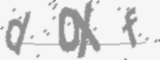

In [4]:
Captcha.generate_image("doxf").convert("L")

In [5]:
def Create_captcha():
    label = ''.join(random.sample(CHARS_SET,CHARS_NUM))
    img = Captcha.generate_image(label).convert("L")
    return label,np.asarray(img,dtype=np.uint8)

In [6]:
def totfrecord(name="train.tfrecord",count=1000):
    with tf.io.TFRecordWriter(name) as writer:
        for _ in range(count):
            label,image_raw = Create_captcha()
            proto = serialize(label,image_raw)
            writer.write(proto)

In [7]:
totfrecord("train.tfrecord",1000)

In [8]:
totfrecord("test.tfrecord",1000)

# TFRecord

In [9]:
image_feature_description={
    "Label" : tf.io.FixedLenFeature([],tf.string),
    "Image_raw" : tf.io.FixedLenFeature([],tf.string),
}

def parse_tf_example(example):
    parse_example = tf.io.parse_single_example(example,image_feature_description)
    image = tf.io.decode_raw(parse_example["Image_raw"],tf.uint8) 
    image = tf.reshape(image,(HEIGHT,WIDTH))
    label = parse_example["Label"]
    
    return label,image

In [10]:
raw_data = tf.data.TFRecordDataset("train.tfrecord")
dataset = raw_data.map(parse_tf_example)
data_ds = dataset.shuffle(buffer_size=1000).batch(10)

for batch,(x,y) in enumerate(data_ds):
    labels = x.numpy()
    img = y
    break

In [11]:
labels

array([b'Gmac', b'cmYp', b'Y0A7', b'SrLk', b'fEau', b'GRhx', b'CDSg',
       b'wZnU', b'fNxz', b'iTmg'], dtype=object)

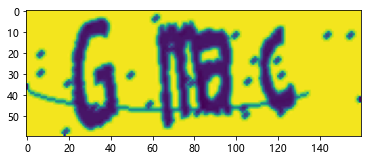

In [13]:
%matplotlib inline
plt.imshow(img[0].numpy())

# Make Model

In [12]:
# model = tf.keras.Sequential()

# model.add(tf.keras.layers.Conv2D(32, (3, 3)))
# model.add(tf.keras.layers.PReLU())
# model.add(tf.keras.layers.MaxPool2D((2, 2), strides=2))

# model.add(tf.keras.layers.Conv2D(64, (5, 5)))
# model.add(tf.keras.layers.PReLU())
# model.add(tf.keras.layers.MaxPool2D((2, 2), strides=2))

# model.add(tf.keras.layers.Conv2D(128, (5, 5)))
# model.add(tf.keras.layers.PReLU())
# model.add(tf.keras.layers.MaxPool2D((2, 2), strides=2))

# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(4 * CHARS_SET_LEN))
# model.add(tf.keras.layers.Reshape([4, CHARS_SET_LEN]))
# model.add(tf.keras.layers.Softmax())

# model.build(input_shape=[None,60,160,1])
# model.compile(optimizer='Adam',
#                   metrics=['accuracy'],
#                   loss='categorical_crossentropy')

# model.save("model")

# Load Model

In [14]:
model = tf.keras.models.load_model("./model")

# Train

In [15]:
def text2vec(text):
    vector = np.zeros([len(text),CHARS_SET_LEN])
    for i,c in enumerate(text):
        idx = CHARS_SET.index(c)
        vector[i][idx] = 1
    return vector

def vec2text(vec):
    text = []
    for i, c in enumerate(vec):
        text.append(CHARS_SET[np.argmax(c)])
    return "".join(text)

In [16]:
def mklabel(label):
    labels = np.zeros([label.shape[0],4,CHARS_SET_LEN])
    for i,c in enumerate(label):
        labels[i] = text2vec(c.decode())
    return tf.constant(labels)

In [17]:
raw_data = tf.data.TFRecordDataset("train.tfrecord")
dataset = raw_data.map(parse_tf_example)
data_ds = dataset.shuffle(buffer_size=1000).batch(500)

for batch,(x,y) in enumerate(data_ds):
    label = mklabel(x.numpy())
    model.fit(y,label,epochs=5)

Epoch 1/5
16/16 [==============================] - 6s 338ms/step - loss: 1.6179 - accuracy: 0.7615
Epoch 2/5
16/16 [==============================] - 5s 341ms/step - loss: 0.5137 - accuracy: 0.8695
Epoch 3/5
16/16 [==============================] - 6s 353ms/step - loss: 0.1416 - accuracy: 0.9585
Epoch 4/5
16/16 [==============================] - 6s 360ms/step - loss: 0.0249 - accuracy: 0.9955
Epoch 5/5
16/16 [==============================] - 7s 421ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 1/5
16/16 [==============================] - 6s 402ms/step - loss: 1.1388 - accuracy: 0.7605
Epoch 2/5
16/16 [==============================] - 6s 366ms/step - loss: 0.3110 - accuracy: 0.9135
Epoch 3/5
16/16 [==============================] - 6s 372ms/step - loss: 0.0419 - accuracy: 0.9925
Epoch 4/5
16/16 [==============================] - 6s 373ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 5/5
16/16 [==============================] - 6s 370ms/step - loss: 0.0018 - accuracy: 1.0000


In [18]:
# model.save("model")

# Predict

In [19]:
raw_data = tf.data.TFRecordDataset("test.tfrecord")
dataset = raw_data.map(parse_tf_example)
data_ds = dataset.shuffle(buffer_size=1000).batch(100)

lst = []

for i, (label, image) in enumerate(data_ds):
    labels = mklabel(label.numpy())
    
    pre = model.predict(image)
    pre_label = list(map(vec2text, pre))

    true_label = list(map(lambda x: x.decode(), label.numpy()))

    p = 0
    for i in range(len(pre_label)):
        for j in range(4):
            if pre_label[i][j] == true_label[i][j]:
                p += 1
    # print("{:.3f}".format(p / (4 * len(pre_label))))
    lst.append(p / (4 * len(pre_label)))

print("final:{}".format(np.array(lst,dtype=float).mean()))

final:0.77575


In [20]:
np.asarray(pre_label),np.asarray(true_label)

(array(['VjwA', '4ggD', '8lR4', '9Gvf', 'pXfc', 'mId0', 'FRRp', 'uqtG',
        '51eq', 'lkqq', 'b56Q', '59lR', 'xqHw', 'mwtX', 'Dmpk', 'rHXv',
        'GgmP', 'wAsS', 'SElh', '6ddg', 'FdAz', 'VGMo', 'iS3h', 'Ajr4',
        'K4AF', 'GTdV', 'JqY0', 'dd3r', '44jS', 'z66D', '1POl', 'PhkY',
        '8PMf', 'Fh7z', 'rrtk', '94zc', 'IEmO', 'Z5Yg', 'Ex9W', 'NtEg',
        'LQtT', 'tlOw', 'E7x7', 'WTAU', 'kklH', 'KMus', 'bnPc', 'z0A3',
        'pAgq', 'H9g7', 'gRTP', '8kPB', 'YZII', 'zKuh', 'FYYf', 'kmfs',
        'UZaa', 'M7Up', 'gRRV', 'yIkE', 'wLRr', 'rSp7', 'V1nz', 'b40R',
        'v6Uf', '9wJ6', 'qiRG', 'rU4A', 'bwjM', 'CPSV', 'NAMK', 'JB0G',
        'Mrlg', 'BMya', '5Tkc', 'YfCU', 'qleS', 'E23y', '7GBy', 'lKd3',
        'K8gR', 'AHWs', 'V0W2', 'FplV', 'qrrf', 'QhGr', 'qPXE', 'U2pE',
        'E6lI', 'zZBC', 'rNNq', 'MGkA', 'wIoB', 'ToPP', '5tKF', 'Zsog',
        '49Vs', 'f3Yb', 'yKrn', 'g3le'], dtype='<U4'),
 array(['vjMA', '4gJT', '81R4', '9Gvf', 'pxfc', 'mId0', 'PKRp', 'uqIG',
        '

In [21]:
%matplotlib tk

fig, ax = plt.subplots(10, 5)
for i in range(10):
    for j in range(5):
        tar = i * 10 + j
        ax[i][j].imshow(image[tar].numpy())
        color = "blue" if pre_label[tar] == true_label[tar] else "red"
        ax[i][j].set_title(f"True: {true_label[tar]}")
        ax[i][j].set_ylabel(pre_label[tar], color=color)